In [78]:
import pandas as pd
import numpy as np
import datetime as dt
import os

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FixedLocator, FixedFormatter

import src.project_definitions as eb

import eblib.utilities as ut
from eblib import style, graphs, physics

In [79]:
def overview_graph(plot_data, ex=False):
    
    plot_data.columns = plot_data.columns.droplevel(level=[0])

    fig = plt.figure(figsize = style.din_a4, constrained_layout=True)
    gs = GridSpec(9,1, figure=fig)
    axs=[]
    i=0
    fig.suptitle(f'Übersicht der Simulationsergebnisse: \n{bauweisen[bui]} | Wohnung {eb.ori[app]} | {room}\n\n', fontweight='bold')
    
    #------ Temperatur ------
    axs.append(fig.add_subplot(gs[0, :]))
    dfp = plot_data.filter(like='TOP').copy()
    axs[i].plot(dfp, label=ut.get_labels(dfp), alpha = 0.75)

    dfp = db[bui].filter(like='Tamb').copy()
    axs[i].plot(dfp, label=ut.get_labels(dfp), alpha = 0.75)

    ut.recolor_lines(axs[i], 'Reds_r' ,minint=0 ,maxint=0.8)

    axs[i].set_title('Temperaturen', fontweight = 'bold')
    axs[i].set_ylabel('Temperatur [°C]')
    axs[i].legend(loc=1)
    i+=1

    #------ Luftwechsel ------
    axs.append(fig.add_subplot(gs[1, :]))
    dfp = plot_data.filter(like='ACR_tot').copy()
    dfp_mean = dfp.rolling('D').mean() #dfp.groupby(dfp.index.floor('5D')).mean()
    avg = float(dfp.mean())
    axs[i].plot(dfp, label='Luftwechselrate', alpha = 0.75)
    axs[i].plot(dfp_mean, label='mittlerer täglicher Luftwechsel', ls='dashed')
    axs[i].axhline(y=avg, linestyle='solid', label = 'mittlerer jährlicher Luftwechsel')
    ut.recolor_lines(axs[i], 'Accent_r')

    axs[i].set_title('Luftwechsel im Airnode', fontweight = 'bold')
    axs[i].set_ylabel('Luftwechselrate [1/h]')
    axs[i].legend(loc=1)
    i+=1

    #------ Luftfeuchte ------
    axs.append(fig.add_subplot(gs[2, :]))
    dfp = plot_data.filter(like='Rh').copy()

    axs[i].plot(dfp, label='Raumluft', alpha = 0.75)

    dfp = amb[bui].apply(lambda x: physics.RH(g=x['X_amb'], t=x['Tamb']),axis=1).copy()

    axs[i].plot(dfp, label='Außenluft', alpha = 0.75)

    ut.recolor_lines(axs[i], 'Blues_r',minint=0.2,maxint=0.8)

    axs[i].set_title('Luftfeuchte', fontweight = 'bold')
    axs[i].set_ylabel('relative Feuchte [%]')
    axs[i].set_ylim(0,100)
    axs[i].legend(loc=1)
    i+=1

    #------ CO2 ------
    axs.append(fig.add_subplot(gs[3, :]))
    dfp = plot_data.filter(like='CO2').copy()

    axs[i].plot(dfp, label=ut.get_labels(dfp), alpha = 0.75)

    ut.recolor_lines(axs[i], 'Greens_r', minint=0,maxint=0.5)

    axs[i].set_title('CO2 Konzentration im Airnode', fontweight = 'bold')
    axs[i].set_ylabel('Konzentration [ppm]')

    for spine in axs[i].spines:
        axs[i].spines[spine].set_visible(False)
    i+=1

    #------ Energie ------
    axs.append(fig.add_subplot(gs[4, :]))
    dfp = plot_data.filter(like='Q_').copy()
    try:
        dfp['Q_dhw'] = dfp.Q_tot_ht-dfp.Q_heat
        dfp.drop('Q_tot_ht',axis=1)
    except:
        pass
    axs[i].plot(dfp, label=ut.get_labels(dfp), alpha = 0.75)

    ut.recolor_lines(axs[i], 'Dark2')

    axs[i].set_title('Energieströme in das (+) und aus (-) dem Airnode', fontweight = 'bold')
    axs[i].set_ylabel('Energie [Wh/m²]')
    axs[i].legend(loc=1)
    i+=1

    #----- Layout Timelines -----
    for ax in axs:
        ax.set_xlim(plot_data.index.min(),plot_data.index.max())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        ax.xaxis.set_major_locator( mdates.MonthLocator())


    #------ Komfortband ------
    
    axs.append(fig.add_subplot(gs[5:7, :]))
    graphs.thermal_comfort_2(amb[bui].Tamb_g24,plot_data.TOP,axs[i], mode='op')
    i+=1
    #------ HX Diagramm ------
   
    axs.append(fig.add_subplot(gs[7:9, :]))
    t1 = plot_data.Tair
    t2 = amb[bui].Tamb
    rh1 = plot_data.Rh
    rh2 = amb[bui].apply(lambda x: physics.RH(g=x['X_amb'], t=x['Tamb']),axis=1)
    graphs.comfort_hx_diagramm(t1 = t1, rh1 = rh1, rh2=rh2, t2=t2, ax=axs[i])

    if ex:
        ut.export(fig,os.path.join(dir_export,bui,'overview'),filename='{}_{}_übersicht'.format(bui,room),extlist=['pdf','svg','png'],extsubfolder=True)

In [80]:
style.set_rc_eb_standard()
ex = False

pfad = r'C:\Users\Roman\TRNLizard\2020-einfach-bauen\varianten'

varianten = {var : os.path.join(pfad, var,'TRNSYS','Model') for var in os.listdir(pfad)}
varianten['aktuell-0.25'] = r'C:\Users\Roman\TRNLizard\2020-einfach-bauen\detailed-0.25\Model'
varianten['aktuell-1'] = r'C:\Users\Roman\TRNLizard\2020-einfach-bauen\detailed-1\Model'

var = input(list(varianten.keys()))
dir_export = os.path.join(os.path.dirname(os.path.dirname(varianten[var])), 'Auswertung')

bauweisen = {'HM':'Massivholz', 'MW':'Ziegel', 'LB':'Leichtbeton'}

airnodes = ['A1_WE1_Wohnen','A2_WE1_Innenflur','A3_WE1_Diele','A4_WE1_Schlafen','A5_WE1_Kueche','A6_WE1_Bad','A16_TH_gesamt','A18_DG_gesamt','A17_TH_gesamt','A7_WE2_Schlafen','A8_WE2_Innenflur','A9_WE2_Bad','A10_WE3_Wohnen','A11_WE3_Innenflur','A12_WE3_Diele','A13_WE3_Schlafen','A14_WE3_Kueche','A15_WE3_Bad','A19_DG_gesamt']

idx = [(item.split('_')[1], item.split('_')[0]) for item in airnodes]
A = pd.Series([21.775,2,6.46,17.85,8.8775, 4.8,0, 0, 0,17.85,2,4.8,15.075,2.0,12.92,17.85,8.8775,4.8,0],pd.MultiIndex.from_tuples(idx))
area = {}
for app in ['WE1','WE2','WE3']:
    try:
        if app not in area:
            area[app] = {}
        area[app]['array'] = A[app]
        area[app]['sum'] = A.groupby(level=0).sum()[app]
        area[app]['%']=(area[app]['array']/area[app]['sum'])
    except:
        continue
    
wohnungairnode = {}
for item in eb.airnodes:
    strings = item.split('_')
    we = strings[1]
    an = strings[0]
    if we not in wohnungairnode:
        wohnungairnode[we] = []
    wohnungairnode[we].append(an)

rooms = []
for item in eb.airnodes:
    strings = item.split('_')
    strings.pop(1)
    rooms.append('-'.join(strings))

approoms = {'WE1': rooms[:6], 'WE2':rooms[9:12],'WE3':rooms[12:18]}

folder = [os.path.join(varianten[var], folder, 'Results') for folder in os.listdir(varianten[var])]

folder = [os.path.join(folder[i], os.listdir(folder[i])[0]) for i in range(len(folder))]

files = {}
for f in folder:
    text = f.split('\\')[-3].split('-')
    bui = text[0]
    side = text[1]
    if bui not in files:
        files[bui] = {}
    files[bui][side] = f

In [81]:
pfad = r'C:\Users\Roman\TRNLizard\2020-einfach-bauen\varianten'
varianten = {var : os.path.join(pfad, var,'TRNSYS','Model') for var in os.listdir(pfad)}
varianten['aktuell-0.25'] = r'C:\Users\Roman\TRNLizard\2020-einfach-bauen\detailed-0.25\Model'
varianten['aktuell-1'] = r'C:\Users\Roman\TRNLizard\2020-einfach-bauen\detailed-1\Model'
varianten


{'Variante_1': 'C:\\Users\\Roman\\TRNLizard\\2020-einfach-bauen\\varianten\\Variante_1\\TRNSYS\\Model',
 'Variante_2': 'C:\\Users\\Roman\\TRNLizard\\2020-einfach-bauen\\varianten\\Variante_2\\TRNSYS\\Model',
 'Variante_3': 'C:\\Users\\Roman\\TRNLizard\\2020-einfach-bauen\\varianten\\Variante_3\\TRNSYS\\Model',
 'aktuell-0.25': 'C:\\Users\\Roman\\TRNLizard\\2020-einfach-bauen\\detailed-0.25\\Model',
 'aktuell-1': 'C:\\Users\\Roman\\TRNLizard\\2020-einfach-bauen\\detailed-1\\Model'}

In [82]:
db = {} #dict.fromkeys([bui.split('-')[0] for bui in os.listdir(pfad)])
amb={}
for bui in files:
    bui_df = []
    for side in files[bui]:
        addout_file=open(files[bui][side],"r")               #open TRNLizard-Output File
        print('reading file: ', files[bui][side])
        addout_lines = [line.split() for line in addout_file.readlines()]     #read file, line-by-line
        addout_lines.pop(0)

        for j, line in enumerate(addout_lines):
            if len(line) == 0:
                data = addout_lines[:j]
                break

        header = data.pop(0)
        df = pd.DataFrame(
            data, 
            columns=header, 
            dtype=float)
        timestep = float(df.Period.diff().dropna().unique())
        df['Period'] = df.Period-timestep
        df['Datetime'] = df['Period'].apply(lambda x: dt.datetime(2020,1,1,0,0) + dt.timedelta((x)/24))
        df.set_index('Datetime', inplace=True)
        bui_df.append(df)

    df = pd.concat(bui_df, axis=1)
    df = df.loc[:,~df.columns.duplicated()]
    amb[bui] = df.iloc[:,:5].copy()
    amb[bui] = amb[bui].resample('H').sum()
    db[bui] = df.resample('H').sum()

    idx=[]

    for item in db[bui].columns:
        split = item.rsplit('_',3)
        if len(split) >= 4:
            idx.append((split[-2],split[-3]+'-'+split[-1],split[-3],split[0]))
        else:
            idx.append(('','','',item))
    if bui not in db:
        db[bui] = {}
    db[bui].columns = pd.MultiIndex.from_tuples(idx)

reading file:  C:\Users\Roman\TRNLizard\2020-einfach-bauen\varianten\Variante_2\TRNSYS\Model\HM-NORD\Results\AddOutput_1h.prn
reading file:  C:\Users\Roman\TRNLizard\2020-einfach-bauen\varianten\Variante_2\TRNSYS\Model\HM-SUED\Results\AddOutput_1h.prn
reading file:  C:\Users\Roman\TRNLizard\2020-einfach-bauen\varianten\Variante_2\TRNSYS\Model\LB-NORD\Results\AddOutput_1h.prn
reading file:  C:\Users\Roman\TRNLizard\2020-einfach-bauen\varianten\Variante_2\TRNSYS\Model\LB-SUED\Results\AddOutput_1h.prn
reading file:  C:\Users\Roman\TRNLizard\2020-einfach-bauen\varianten\Variante_2\TRNSYS\Model\MW-NORD\Results\AddOutput_1h.prn
reading file:  C:\Users\Roman\TRNLizard\2020-einfach-bauen\varianten\Variante_2\TRNSYS\Model\MW-SUED\Results\AddOutput_1h.prn


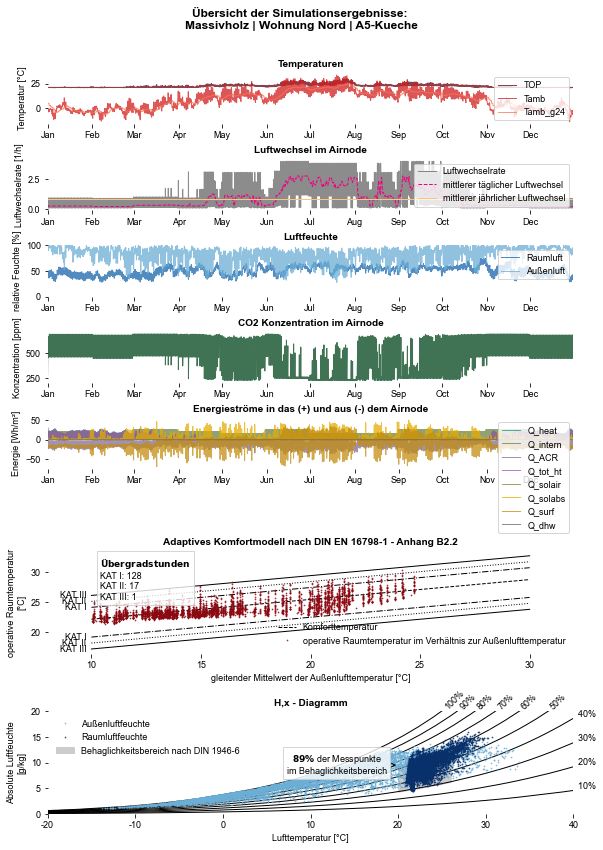

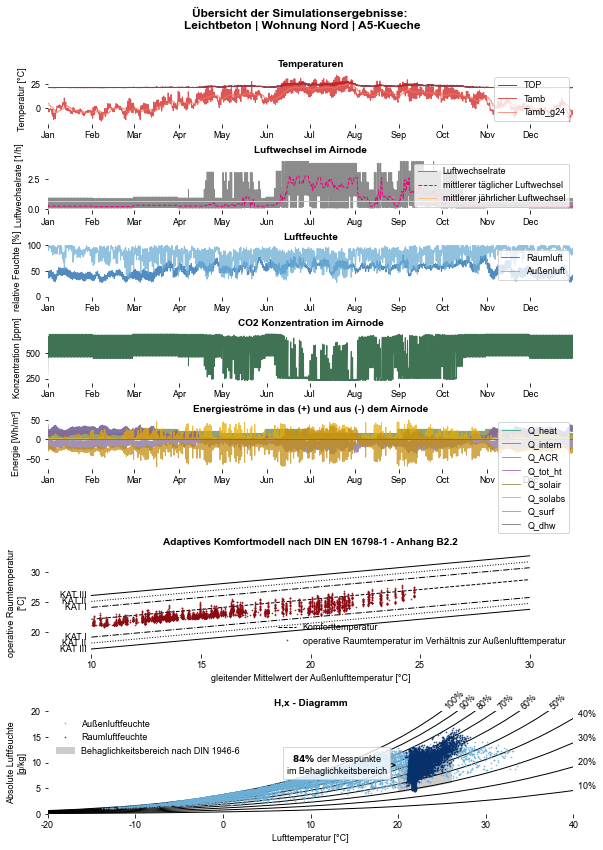

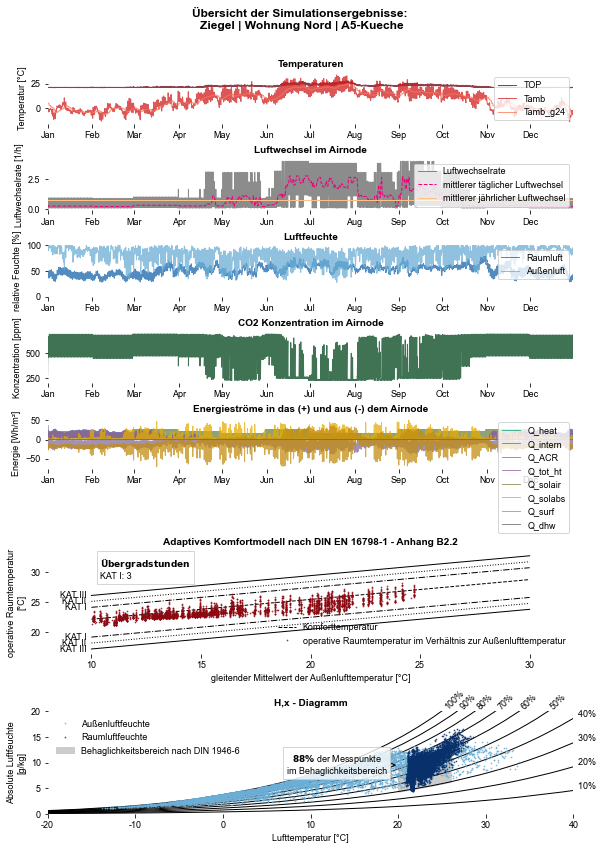

In [83]:
if ex == False:
    for bui in db:
        app = 'WE1'
        room = approoms[app][4]

        plot_data = db[bui][app][room]

        overview_graph(plot_data,ex=ex)

In [84]:
if ex:
    for bui in db:
        for app in eb.wohnungen2:
            for room in rooms:
                try:
                    plot_data = db[bui][app][room]
                except:
                    continue
                overview_graph(plot_data, ex=ex)

In [85]:
(db[bui].groupby(level=3,axis=1).get_group('Q_tot_ht')).sum().droplevel(level=[1,3])*eb.A

WE1  A1     1.103109e+06
     A2     2.682980e+04
     A3     4.891346e+05
     A4     9.601415e+05
     A5     3.885990e+05
     A6     1.378770e+06
TH   A16    0.000000e+00
DG   A18    0.000000e+00
TH   A17    0.000000e+00
WE2  A7     9.322066e+05
     A8     1.879502e+05
     A9     7.725980e+05
WE3  A10    8.464260e+05
     A11    2.006968e+04
     A12    8.290840e+05
     A13    6.745294e+05
     A14    3.708347e+05
     A15    1.306529e+06
DG   A19    0.000000e+00
dtype: float64

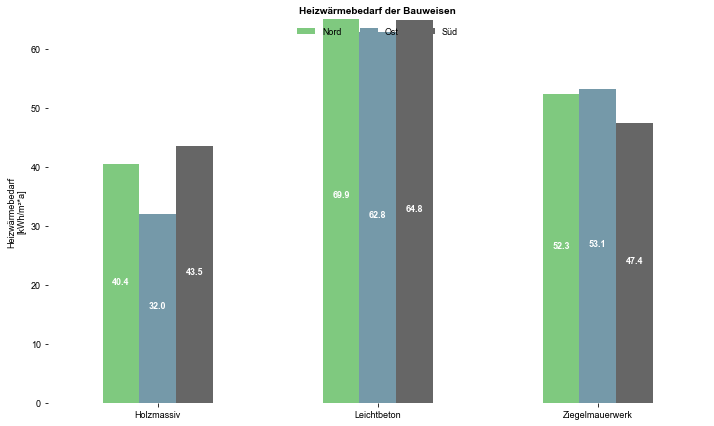

In [86]:
fig, axs = plt.subplots(figsize=style.in_doc)

qht = []
colnames = []
for i, bui in enumerate(db):
    qht.append((((db[bui].groupby(level=[3],axis=1).get_group('Q_heat').sum().droplevel(level=[1,3])*eb.A).groupby(level=0).sum()))/eb.A.groupby(level=0).sum()/1000)
    colnames.append(bui)

df = pd.concat(qht,axis=1)
df.columns = colnames
df.dropna(inplace=True)
df.index = ['Nord', 'Ost','Süd']
df.T.plot.bar(ax = axs,cmap=ut.truncate_colormap('Accent'))

axs.set_title('Heizwärmebedarf der Bauweisen', fontweight = 'bold')
axs.set_ylabel('Heizwärmebedarf\n[kWh/m²*a]')
axs.set_ylim(0,65)
axs.set_xticklabels(['Holzmassiv', 'Leichtbeton', 'Ziegelmauerwerk'], rotation=0)
xticks=[]
for bar in axs.patches:
    xticks.append(bar.get_x())

    axs.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height()*0.5 + bar.get_y(),
        round(bar.get_height(),1),
        ha='center',
        color='w',
        weight='bold',
        )
axs.legend(loc='upper center',frameon=False,ncol=3)

fig.tight_layout()
if ex:
    ut.export(fig,dir_export,'Vergleich_Heizwärmebedarf',extlist=['pdf','svg','png'],extsubfolder=True)


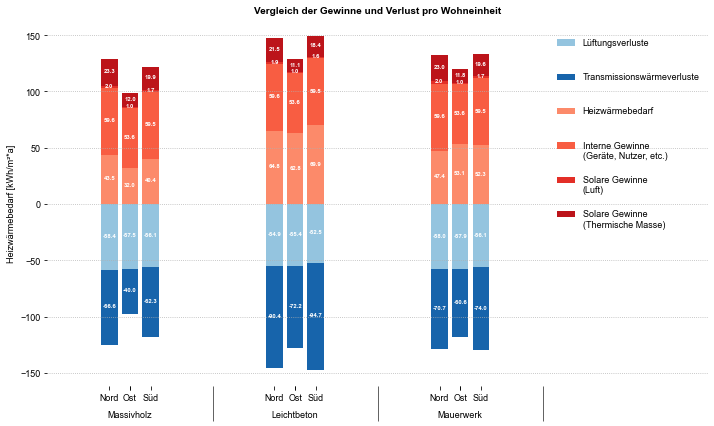

In [87]:
Q={}
for b, bui in enumerate(db):
    #print('---------{}---------'.format(bui))   
    if bui not in Q:
        Q[bui] = {}
    for a, app in enumerate(eb.wohnungen2):
        try:
            if app not in Q[bui]:
                Q[bui][app] = {}
            A_we = np.array(eb.A.filter(like=app))
            A_sum = np.array(eb.A.filter(like=app)).sum()
            #print('------{}------'.format(app))
            for meter in ['Q_heat', 'Q_intern', 'Q_ACR','Q_surf','Q_solair','Q_solabs']:
                Q[bui][app][meter] = round((db[bui][app].filter(like=meter).sum()*A_we).sum()/A_sum/1000,2)
                #print('{}: {} [kWh/m²]'.format(meter, Q[bui][app][meter]))
        except:
            continue

Q = pd.DataFrame.from_dict({(i,j): Q[i][j] 
                           for i in Q.keys() 
                           for j in Q[i].keys()},
                       orient='index').T

Q.columns = Q.columns.swaplevel(0,1)
Q.dropna(axis=1,inplace=True)
Q.sort_index(inplace=True, axis=1)

fig,axs = plt.subplots(figsize=style.in_doc)

w = 0.1

cmap = plt.get_cmap('Reds')
red = ut.truncate_colormap(cmap, 0.4, 0.8)

cmap = plt.get_cmap('Blues')
green = ut.truncate_colormap(cmap, 0.4, 0.8)

we1 = Q.sort_index(axis=1)['WE1'].T
we1[we1<0].dropna(axis=1).plot.bar(stacked=True,width = w, position = -0.75,ax=axs,cmap=green)
we1[we1>0].dropna(axis=1).plot.bar(stacked=True,width = w, position = -0.75,ax=axs,cmap=red)

we2 = Q.sort_index(axis=1)['WE2'].T
we2[we2<0].dropna(axis=1).plot.bar(stacked=True,width = w, position = 0.5,ax=axs,cmap=green)
we2[we2>0].dropna(axis=1).plot.bar(stacked=True,width = w, position = 0.5,ax=axs,cmap=red)

we3 = Q.sort_index(axis=1)['WE3'].T
we3[we3<0].dropna(axis=1).plot.bar(stacked=True,width = w, position = 1.75,ax=axs,cmap=green)
we3[we3>0].dropna(axis=1).plot.bar(stacked=True,width = w, position = 1.75,ax=axs,cmap=red)

xticks=[]
for bar in axs.patches:
    xticks.append(bar.get_x())

    axs.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height()*0.5 + bar.get_y(),
        round(bar.get_height(),1),
        ha='center',
        color='w',
        size=6,
        weight='bold',
        )

xticks = [x+(w*0.5) for x in list(dict.fromkeys(xticks))]
xticks.sort()

ax2 = axs.twiny()
ax2.set_xticks(xticks)

axs.set_xlim(-0.5,3.5)
ax2.set_xlim(-0.5,3.5)

ax2.set_xticklabels(['Nord','Ost','Süd','Nord','Ost','Süd','Nord','Ost','Süd',])
ax2.xaxis.tick_bottom()

x_locator = FixedLocator([0,1,2])
x_formatter = FixedFormatter(['Massivholz','Leichtbeton','Mauerwerk'])


x_locator = FixedLocator([0.5, 1.5, 2.5])
ax2.xaxis.set_minor_locator(x_locator)

axs.set_xticks([0,1,2])
axs.set_xticklabels(['Massivholz','Leichtbeton','Mauerwerk'],rotation = 0)
axs.tick_params(axis = 'x', which='major', pad=20)

ax2.tick_params(axis = 'x', which='minor', length=35)

axs.legend(
    labels=['\nLüftungsverluste\n', '\nTransmissionswärmeverluste\n', '\nHeizwärmebedarf\n', '\nInterne Gewinne\n(Geräte, Nutzer, etc.)', '\nSolare Gewinne\n(Luft)', '\nSolare Gewinne\n(Thermische Masse)'],
    handles=axs.get_legend_handles_labels()[0][:6],
    frameon=False,
    )

for spine in axs.spines:
    axs.spines[spine].set_visible(False)

for spine in ax2.spines:
    ax2.spines[spine].set_visible(False)

axs.grid(axis='y',linestyle='dotted')

axs.set_ylabel('Heizwärmebedarf [kWh/m²*a]')

axs.set_title('Vergleich der Gewinne und Verlust pro Wohneinheit', fontweight = 'bold')

fig.tight_layout()
if ex:
    ut.export(fig,dir_export,'Vergleich_Gewinne_u_Verluste',['pdf','svg','png'],extsubfolder=True )

In [88]:
Q={}
for b, bui in enumerate(db):
    if bui not in Q:
        Q[bui] = {}
    for a, app in enumerate(eb.wohnungen2):
        try:
            if app not in Q[bui]:
                Q[bui][app] = {}
            A_we = np.array(eb.A.filter(like=app))
            A_sum = np.array(eb.A.filter(like=app)).sum()
            #print('------{}------'.format(app))
            for meter in ['Q_heat', 'Q_intern', 'Q_ACR','Q_surf','Q_solair','Q_solabs','Q_tot_ht']:
                Q[bui][app][meter] = round((db[bui][app].filter(like=meter).sum()*A_we).sum()/A_sum/1000,2)
                #print('{}: {} [kWh/m²]'.format(meter, Q[bui][app][meter]))
        except:
            continue

Q = pd.DataFrame.from_dict({(i,j): Q[i][j] 
                           for i in Q.keys() 
                           for j in Q[i].keys()},
                       orient='index').T

Q.columns = Q.columns.swaplevel(0,1)
Q.dropna(axis=1,inplace=True)
Q.sort_index(inplace=True, axis=1)


exdir = os.path.join(eb.dir_results,'Simulation')
if os.path.isdir(exdir)==False: os.makedirs(exdir)
Q.to_csv(os.path.join(exdir,f'Energie_{var}.csv'))

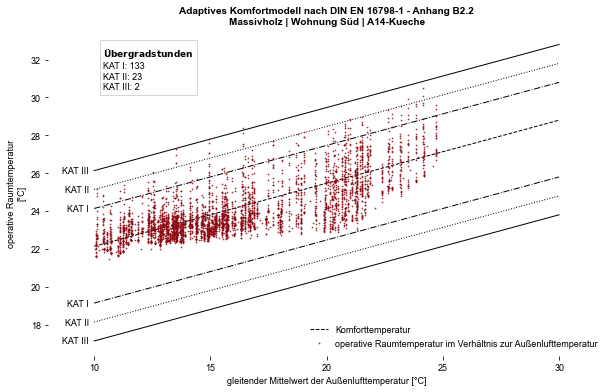

In [89]:
bui='HM'
app='WE3'
room=approoms[app][4]

fig,axs = plt.subplots()
graphs.thermal_comfort_2(amb[bui].Tamb_g24,db[bui][app][room].droplevel(level=0,axis=1).TOP,axs,mode='op')
axs.set_title(f'Adaptives Komfortmodell nach DIN EN 16798-1 - Anhang B2.2\n{bauweisen[bui]} | Wohnung {eb.ori[app]} | {room}',fontweight = 'bold')

if ex:
    for bui in db:
        for app in eb.wohnungen2:
            for room in rooms:
                if room in db[bui][app].columns:
                    fig,axs = plt.subplots(figsize=(15,10))
                    try:
                        graphs.thermal_comfort_2(amb[bui].Tamb_g24,db[bui][app][room].droplevel(level=0,axis=1).TOP,axs,mode='op')
                        axs.set_title(f'Adaptives Komfortmodell nach DIN EN 16798-1 - Anhang B2.2\n{bauweisen[bui]} | Wohnung {eb.ori[app]} | {room}',fontweight = 'bold')
                        ut.export(fig,os.path.join(dir_export,bui,'comfort'),f'{bui}_{app}_{room}_adaptive_comfort',['pdf','svg','png'])
                        #print('{} | {} | {} erfolgreich exportiert!'.format(bauweisen[bui],app, room))
                    except:
                        continue

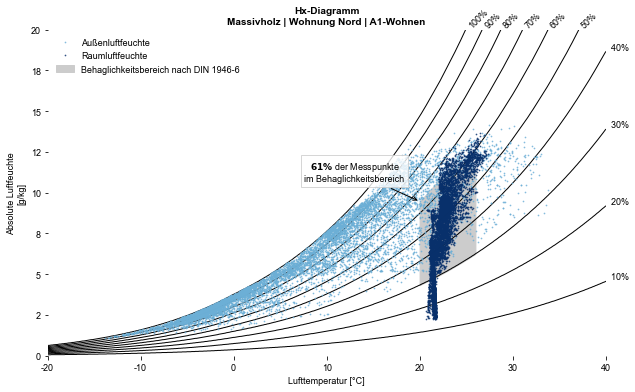

In [90]:
app='WE1'
room='A1-Wohnen'

fig,axs = plt.subplots(figsize=style.in_doc)
t1 = db[bui][app][room].droplevel(level=0,axis=1).Tair
t2 = amb[bui].Tamb
rh1 = db[bui][app][room].droplevel(level=0,axis=1).Rh
rh2 = amb[bui].apply(lambda x: physics.RH(g=x['X_amb'], t=x['Tamb']),axis=1)
graphs.comfort_hx_diagramm(t1 = t1, rh1 = rh1, rh2=rh2, t2=t2, ax=axs)
axs.set_title(f'Hx-Diagramm\n{bauweisen[bui]} | Wohnung {eb.ori[app]} | {room}',fontweight = 'bold')

if ex:
    for bui in db:
        for app in eb.wohnungen2:
            for room in rooms:
                if room in db[bui][app].columns:
                    try:
                        fig,axs = plt.subplots(figsize=(15,10))
                        t1 = db[bui][app][room].droplevel(level=0,axis=1).Tair
                        t2 = amb[bui].Tamb
                        rh1 = db[bui][app][room].droplevel(level=0,axis=1).Rh
                        rh2 = amb[bui].apply(lambda x: physics.RH(g=x['X_amb'], t=x['Tamb']),axis=1)
                        graphs.comfort_hx_diagramm(t1 = t1, rh1 = rh1, rh2=rh2, t2=t2, ax=axs)
                        axs.set_title(f'Hx-Diagramm\n{bauweisen[bui]} | Wohnung {eb.ori[app]} | {room}',fontweight = 'bold')
                        ut.export(fig,os.path.join(dir_export,bui,'hx'),f'{bui}_{app}_{room}_hx',['pdf','svg','png'])
                    except:
                        continue

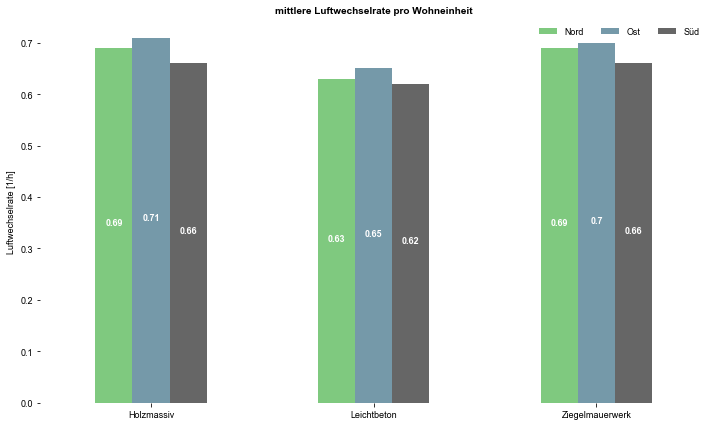

In [91]:
acr = {}

for bui in db:
    if bui not in acr:
        acr[bui]={}
        for app in eb.wohnungen2:
            try:
                acr_app = round((db[bui][app].filter(like='ACR_tot').mean().droplevel([0,2])*area[app]['%']).sum(),2)
                acr[bui][app] = acr_app
            except:
                continue

fig,axs = plt.subplots(figsize=style.in_doc)
df = pd.DataFrame.from_dict(acr).T
df.columns = ['Nord','Ost','Süd']
df.plot.bar(ax=axs,cmap=ut.truncate_colormap('Accent'))

axs.set_xticklabels(['Holzmassiv', 'Leichtbeton', 'Ziegelmauerwerk'], rotation=0)
axs.set_title('mittlere Luftwechselrate pro Wohneinheit',fontweight = 'bold')
axs.set_ylabel('Luftwechselrate [1/h]')
xticks=[]
for bar in axs.patches:
    xticks.append(bar.get_x())

    axs.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height()*0.5 + bar.get_y(),
        round(bar.get_height(),2),
        ha='center',
        color='w',
        weight='bold',
        )
axs.legend(frameon=False,ncol=3)

fig.tight_layout()
if ex:
    ut.export(fig,dir_export,'mittlere_Luftwechselraten',['pdf','svg','png'])

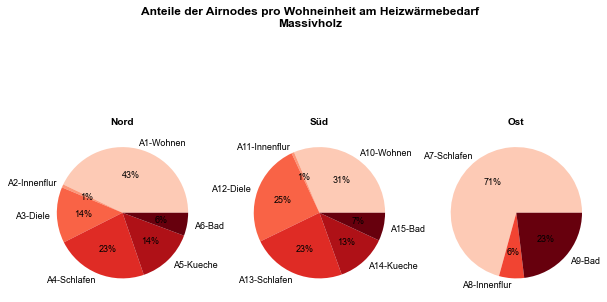

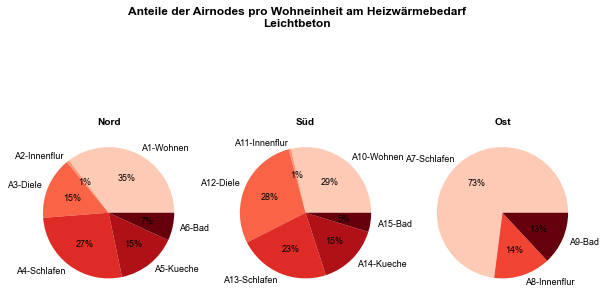

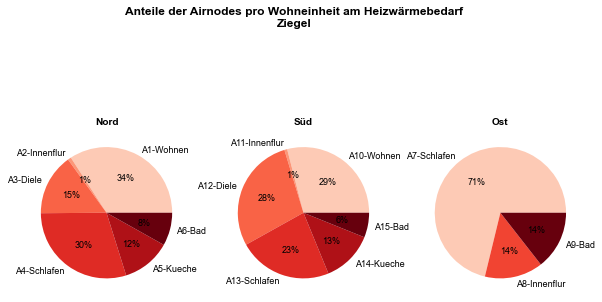

In [92]:
app = 'WE1'
room = 'A6-Bad'

for bui in db:
    fig, axs = plt.subplots(1,3, figsize=style.in_doc)
    for a, app in enumerate(eb.wohnungen2):
        df = (db[bui][app].groupby(level=2,axis=1).get_group('Q_heat').sum().droplevel([0,2])*area[app]['%'])

        df = pd.DataFrame(df)

        df.index = approoms[app]

        df.columns = ['Q_heat']

        df.plot.pie(y='Q_heat',ax=axs[a], autopct='%1.0f%%', cmap=ut.truncate_colormap('Reds',0.2))

        axs[a].set_title(f'{eb.ori[app]}')
        axs[a].legend().remove()
        axs[a].set_ylabel('')

    fig.suptitle(f'Anteile der Airnodes pro Wohneinheit am Heizwärmebedarf\n{bauweisen[bui]}',fontweight = 'bold')
    fig.set_facecolor('white')
    fig.get_constrained_layout()
    if ex:
        ut.export(fig, os.path.join(dir_export,bui),f'{bui}_Vergleich_Heizwärmebedarf',['pdf','svg','png'] )

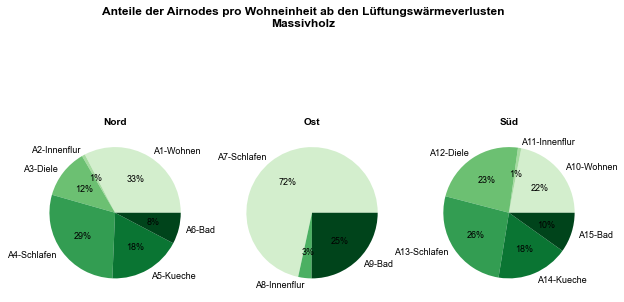

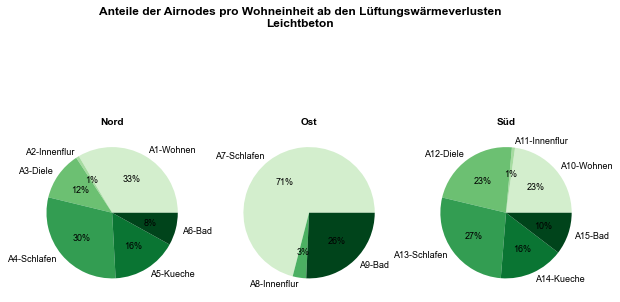

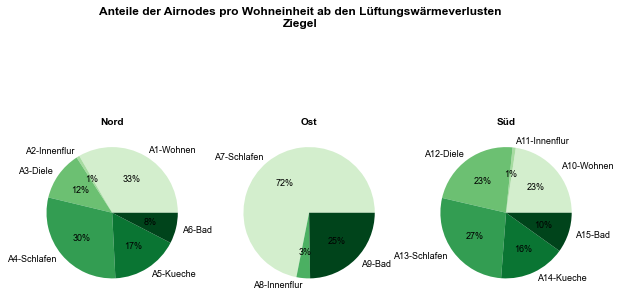

In [93]:
app = 'WE1'
room = 'A6-Bad'

for bui in db:
    fig, axs = plt.subplots(1,3, figsize=style.in_doc)
    for a, app in enumerate(eb.ori):
        df = (db[bui][app].groupby(level=2,axis=1).get_group('Q_ACR').sum().droplevel([0,2])*area[app]['%'])

        df = pd.DataFrame(df)

        df.index = approoms[app]

        df.columns = ['Q_ACR']

        df.abs().plot.pie(y='Q_ACR',ax=axs[a], autopct='%1.0f%%', cmap=ut.truncate_colormap('Greens',0.2))
        axs[a].set_title(f'{eb.ori[app]}')
        axs[a].legend().remove()
        axs[a].set_ylabel('')

    fig.suptitle(f'Anteile der Airnodes pro Wohneinheit ab den Lüftungswärmeverlusten\n{bauweisen[bui]}',fontweight = 'bold')
    fig.set_facecolor('white')
    if ex:
        ut.export(fig, os.path.join(dir_export,bui),f'{bui}_Vergleich_Lüftungswärmeverluste',['pdf','svg','png'])

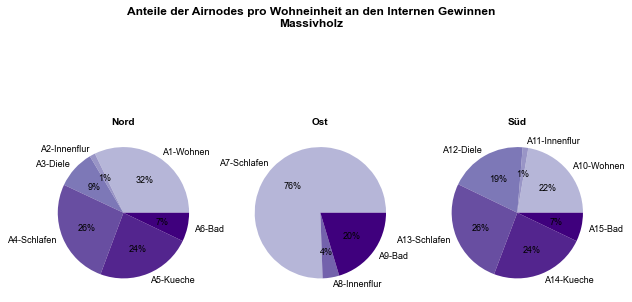

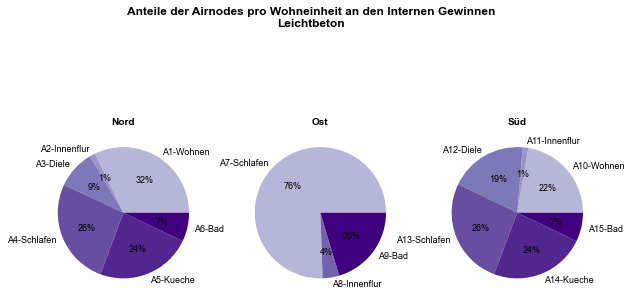

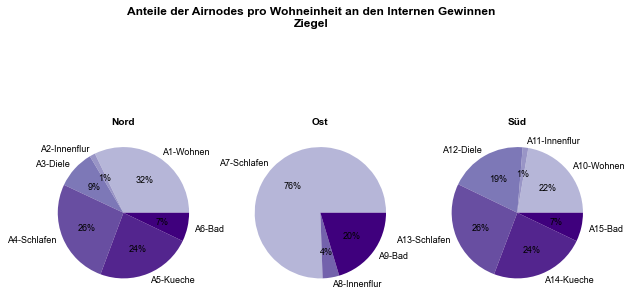

In [94]:
app = 'WE1'
room = 'A6-Bad'
gain = 'Q_intern'
loss = False

for bui in db:
    fig, axs = plt.subplots(1,3, figsize=style.in_doc)
    for a, app in enumerate(eb.ori):
        df = (db[bui][app].groupby(level=2,axis=1).get_group(gain).sum().droplevel([0,2])*area[app]['%'])

        df = pd.DataFrame(df)

        df.index = approoms[app]

        df.columns = [gain]

        if loss:
            df = df.abs()

        df.plot.pie(y=gain,ax=axs[a], autopct='%1.0f%%', cmap=ut.truncate_colormap('Purples',0.4))
        axs[a].set_title(f'{eb.ori[app]}')
        axs[a].legend().remove()
        axs[a].set_ylabel('')

    fig.suptitle(f'Anteile der Airnodes pro Wohneinheit an den Internen Gewinnen\n{bauweisen[bui]}',fontweight = 'bold')
    fig.set_facecolor('white')
    if ex:
        ut.export(fig, os.path.join(dir_export,bui),f'{bui}_Vergleich_Interne_Gewinne',['pdf','svg','png'])